# Frequentist models with PC1

**Importing required libraries**

In [829]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
#from scipy.sparse import csr_matrix
#from scipy import sparse
#from libpysal.weights.util import get_points_array_from_shapefile
#from libpysal.weights import Queen
#import contextily as ctx
#import libpysal as lps
import pysal.lib
from thefuzz import process
from thefuzz import fuzz
import pysal.model.spreg
from spreg import ML_Lag, ML_Error, GM_Error
import geopandas as gpd
from libpysal import weights
import matplotlib.pyplot as plt
from pysal.model.spreg import GM_Error_Het
from pysal.lib import weights
from pysal.model import spreg
import seaborn as sn
from sklearn.metrics import mean_squared_error, r2_score

## Change below parameters to perform the required analysis

1. Add the Poverty metric: 
    - Whole country:    1
    - Urban:            2
    - Rural:            3
    

2. Data type:
    - RS +CDR:          1
    - RS only:          2
    - CDR only:         3
    

3. Model Type:

    - SDEM:             1
        (Spatial Durbin Error Model)
    - SEM:              2
        (Spatial Error Model)
    - SLX:              3
        (Spatial Lag Model)


In [830]:
povery_metric = 2
data_type = 2
model_type = 3

**Importing the datasets**: 
Assigning the file paths of call detail records, remote sensing data, and principle component analysis data to mobile_path, satellite_path, and pca_path respectively

In [831]:
mobile_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/mobile_features.csv'
satellite_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/satellite_features.csv'
pca_path = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/pca_census.csv'
urban_rural = '/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/GND_urban_rural_classification.csv'

## Data Cleaning

In [832]:
#Reading Ground truth DATA and filtering zero population gnds (Grama niladhari divisions are referred to as gnd, which are the smallest diviions in Sri Lanka)
data_pca = pd.read_csv(pca_path)
missing_gnd_ids = data_pca.loc[data_pca['PC1'].isnull(), 'gnd_id']
count = missing_gnd_ids.count()
print('No of gnds with zero population:',count)

# Read the datasets and merge into a single pandas dataframe
data_raw = pd.read_csv(mobile_path).merge(pd.read_csv(satellite_path), on='gnd_id').merge(pd.read_csv(pca_path), on='gnd_id').rename(columns={"PC1": "pc1"}).set_index('gnd_id')

#Removing the zero population gnds from the dataframe
data_raw = data_raw[~data_raw.index.isin(missing_gnd_ids)]

No of gnds with zero population: 37


### Data breakdown interms of urban rural classification

In [833]:
urb_rur = pd.read_csv('/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/GND_urban_rural_classification.csv')
print(urb_rur['urbanity'].value_counts())
urban_gnds = urb_rur.loc[urb_rur['urbanity'] == 'Urban', 'gnd_id']
rural_gnds = urb_rur.loc[urb_rur['urbanity'] == 'Rural', 'gnd_id']

if povery_metric == 1:
    pass
elif povery_metric == 2:
    data_raw = data_raw[data_raw.index.isin(urban_gnds)]
elif povery_metric == 3:
    data_raw = data_raw[data_raw.index.isin(rural_gnds)]

urbanity
Rural    12806
Urban     1216
Name: count, dtype: int64


## Data Processing

In [834]:
# Log transform skewed variables

data_unskewed = data_raw[[

    #Call detail records
    "call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",

    #Remote Sensing data
    "travel_time_major_cities",
    "population_count_worldpop",
    "population_count_ciesin",
    "population_density",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk",
    "distance_roadways_primary",
    "distance_roadways_secondary",
    "distance_roadways_tertiary",
    "distance_waterways",
    "urban_rural_fb",
    "urban_rural_ciesin",
    "global_human_settlement",
    "protected_areas",
    "land_cover_woodland",
    "land_cover_grassland",
    "land_cover_cropland",
    "land_cover_wetland",
    "land_cover_bareland",
    "land_cover_urban",
    "land_cover_water",
    "pregnancies",
    "births",
    "precipitation",
    "temperature",

    "pc1"
]].copy()

# Log transform skewed variables
data_unskewed.loc[:, "radius_of_gyration_log"] = np.log(data_unskewed["radius_of_gyration"])
data_unskewed.loc[:, "travel_time_major_cities_log"] = np.log(data_unskewed["travel_time_major_cities"] + 1)
data_unskewed.loc[:, "population_count_worldpop_log"] = np.log(data_unskewed["population_count_worldpop"] + 1)
data_unskewed.loc[:, "population_count_ciesin_log"] = np.log(data_unskewed["population_count_ciesin"] + 1)
data_unskewed.loc[:, "population_density_log"] = np.log(data_unskewed["population_density"])
data_unskewed.loc[:, "elevation_log"] = np.log(data_unskewed["elevation"] + 1)
data_unskewed.loc[:, "distance_roadways_trunk_log"] = np.log(data_unskewed["distance_roadways_trunk"] + 1)
data_unskewed.loc[:, "distance_roadways_primary_log"] = np.log(data_unskewed["distance_roadways_primary"] + 1)
data_unskewed.loc[:, "distance_roadways_secondary_log"] = np.log(data_unskewed["distance_roadways_secondary"] + 1)
data_unskewed.loc[:, "distance_roadways_tertiary_log"] = np.log(data_unskewed["distance_roadways_tertiary"] + 1)
data_unskewed.loc[:, "distance_waterways_log"] = np.log(data_unskewed["distance_waterways"] + 1)
data_unskewed.loc[:, "urban_rural_fb_log"] = np.log(data_unskewed["urban_rural_fb"] + 1)
data_unskewed.loc[:, "global_human_settlement_log"] = np.log(data_unskewed["global_human_settlement"] + 1)
data_unskewed.loc[:, "protected_areas_log"] = np.log(data_unskewed["protected_areas"] + 1)
data_unskewed.loc[:, "land_cover_grassland_log"] = np.log(data_unskewed["land_cover_grassland"] + 1)
data_unskewed.loc[:, "land_cover_wetland_log"] = np.log(data_unskewed["land_cover_wetland"] + 1)
data_unskewed.loc[:, "land_cover_bareland_log"] = np.log(data_unskewed["land_cover_bareland"] + 1)
data_unskewed.loc[:, "land_cover_water_log"] = np.log(data_unskewed["land_cover_water"] + 1)
data_unskewed.loc[:, "pregnancies_log"] = np.log(data_unskewed["pregnancies"])
data_unskewed.loc[:, "births_log"] = np.log(data_unskewed["births"])

In [835]:
if data_type == 1:
    data_unskewed = data_unskewed.drop(columns=["radius_of_gyration", "travel_time_major_cities", "population_count_worldpop", "population_count_ciesin", "population_density", "elevation", "distance_roadways_trunk", "distance_roadways_primary", "distance_roadways_secondary", "distance_roadways_tertiary", "distance_waterways", "urban_rural_fb", "global_human_settlement", "protected_areas", "land_cover_grassland", "land_cover_wetland", "land_cover_bareland", "land_cover_water", "pregnancies", "births"])

elif data_type == 2:    
    
    rs_only = data_unskewed[[
        "travel_time_major_cities_log",
        "population_count_worldpop_log",
        "population_count_ciesin_log",
        "population_density_log",
        "aridity_index",
        "evapotranspiration",
        "nighttime_lights",
        "elevation_log",
        "vegetation",
        "distance_roadways_motorway",
        "distance_roadways_trunk_log",
        "distance_roadways_primary_log",
        "distance_roadways_secondary_log",
        "distance_roadways_tertiary_log",
        "distance_waterways_log",
        "urban_rural_fb_log",
        "urban_rural_ciesin",
        "global_human_settlement_log",
        "protected_areas_log",
        "land_cover_woodland",
        "land_cover_grassland_log",
        "land_cover_cropland",
        "land_cover_wetland_log",
        "land_cover_bareland_log",
        "land_cover_urban",
        "land_cover_water_log",
        "pregnancies_log",
        "births_log",
        "precipitation",
        "temperature",

        "pc1"
    ]].copy()

    data_unskewed = rs_only.copy()

elif data_type == 3:
    
    cdr_only = data_unskewed[[
        "call_count",
            "avg_call_duration",
            "nighttime_call_count",
            "avg_nighttime_call_duration",
            "incoming_call_count",
            "avg_incoming_call_duration",
            "radius_of_gyration",
            "unique_tower_count",
            "spatial_entropy",
            "avg_call_count_per_contact",
            "avg_call_duration_per_contact",
            "contact_count",
            "social_entropy",
            "pc1" 
    ]].copy()

    data_unskewed = cdr_only.copy()

    

In [836]:
#fill missing values with their mean
data_unskewed.fillna(data_unskewed.mean(), inplace=True)
data_unskewed.isna().sum()

travel_time_major_cities_log       0
population_count_worldpop_log      0
population_count_ciesin_log        0
population_density_log             0
aridity_index                      0
evapotranspiration                 0
nighttime_lights                   0
elevation_log                      0
vegetation                         0
distance_roadways_motorway         0
distance_roadways_trunk_log        0
distance_roadways_primary_log      0
distance_roadways_secondary_log    0
distance_roadways_tertiary_log     0
distance_waterways_log             0
urban_rural_fb_log                 0
urban_rural_ciesin                 0
global_human_settlement_log        0
protected_areas_log                0
land_cover_woodland                0
land_cover_grassland_log           0
land_cover_cropland                0
land_cover_wetland_log             0
land_cover_bareland_log            0
land_cover_urban                   0
land_cover_water_log               0
pregnancies_log                    0
b

## correlation matrix

#### Removing highly correlated variables

In [837]:
if data_type == 1:

    correlation_matrix = data_unskewed.corr()

    # Highly Correlated Covariates
    high_correlation_threshold = 0.70
    high_correlation_pairs = np.where(np.abs(correlation_matrix) > high_correlation_threshold)

    covariates_to_drop = set()
    for i, j in zip(*high_correlation_pairs):
        if i != j and i not in covariates_to_drop and j not in covariates_to_drop:
            covariate_i = correlation_matrix.columns[i]
            covariate_j = correlation_matrix.columns[j]
            # Check if 'pc_1' is involved in the pair
            if 'pc_1' in (covariate_i, covariate_j):
                
                if covariate_i != 'pc_1':
                    covariates_to_drop.add(covariate_i)
                if covariate_j != 'pc_1':
                    covariates_to_drop.add(covariate_j)
            else:
                # Choose which covariate to drop based on your criteria
                # For example, drop the one with lower relevance
                # or keep the one with higher theoretical importance
                # or drop the one that contributes less to the analysis
                # Here, we simply drop the one with higher index
                if i > j:
                    covariates_to_drop.add(covariate_i)
                else:
                    covariates_to_drop.add(covariate_j)

    covariates_to_drop = {
        'avg_call_count_per_contact',
        'distance_roadways_tertiary_log',
        'global_human_settlement_log',
        'precipitation',
        'unique_tower_count',
        'urban_rural_fb_log'}

    data_unskewed = data_unskewed.drop(columns=covariates_to_drop)

    # Verify Multicollinearity Reduction (optional)
    #correlation_matrix_cleaned = df_cleaned.corr()

## Data stratification based on Province

In [838]:
'''
The province id is included in every gnd id's first digit 

ex: if gnd id starts with 23405....
    its corresponding province id is 2

Below data stratification is done as to represent 80 percent of gnds within a province

'''

province = data_unskewed.index.astype(str).str[0] 


X_train, X_test, y_train, y_test = train_test_split(data_unskewed.drop(columns=["pc1"]), data_unskewed["pc1"], stratify=province, test_size=0.2)

In [839]:
''' 
Normalize and remove highly correlated and near-zero variance variables (scaling the data to have a mean of 0 and a standard deviation of 1)
'''

scaler_train = StandardScaler()
data_train_scaled = scaler_train.fit_transform(X_train)

scaler_test = StandardScaler()
data_test_scaled = scaler_test.fit_transform(X_test)

scaler_full = StandardScaler()
data_full_scaled = scaler_full.fit_transform(data_unskewed.drop(columns="pc1"))

# Convert the scaled data back to a DataFrame
data_full_scaled = pd.DataFrame(data_full_scaled, columns=data_unskewed.columns.drop("pc1"))
data_full_scaled["pc1"] = data_unskewed["pc1"]

data_train_scaled = pd.DataFrame(data_train_scaled, columns=X_train.columns)
data_train_scaled.index = X_train.index


data_test_scaled = pd.DataFrame(data_test_scaled, columns=X_test.columns)
data_test_scaled.index = X_test.index

#data_train_scaled = x train
#data_test_scaled = x test



## Processing Sri Lanka shapefile

In [840]:
data_shapefile = gpd.read_file("/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/sri_lanka_gnd_shape_files/sri_lanka_gnd.shp")

#In the shape file, code_7 column corresponds to the gnd id
data_shapefile.set_index("code_7", inplace=True)
data_shapefile = data_shapefile.to_crs(epsg=3857)

#total data merge with the shapefile
merged = data_unskewed.merge(data_shapefile, left_on=data_unskewed.index, right_on='code_7', how='inner')
gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)
merged = merged.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])

#train set merge with the shapefile
merged_train = data_train_scaled.merge(data_shapefile, left_on=data_train_scaled.index, right_on='code_7', how='inner')
gdf_train = gpd.GeoDataFrame(merged_train, geometry='geometry', crs=data_shapefile.crs)
gdf_train = gdf_train.to_crs(epsg=3857)
merged_train = merged_train.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])

#test data merge with the shapefile
merged_test = data_test_scaled.merge(data_shapefile, left_on=data_test_scaled.index, right_on='code_7', how='inner')
gdf_test = gpd.GeoDataFrame(merged_test, geometry='geometry', crs=data_shapefile.crs)
gdf_test = gdf_test.to_crs(epsg=3857)
merged_test = merged_test.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])

**The Sri Lankan map**: Red indicates gnds with population, while gray indicates the gnds with zero population

(np.float64(8854053.430712115),
 np.float64(9126918.94253964),
 np.float64(638018.8213061832),
 np.float64(1122278.6930524309))

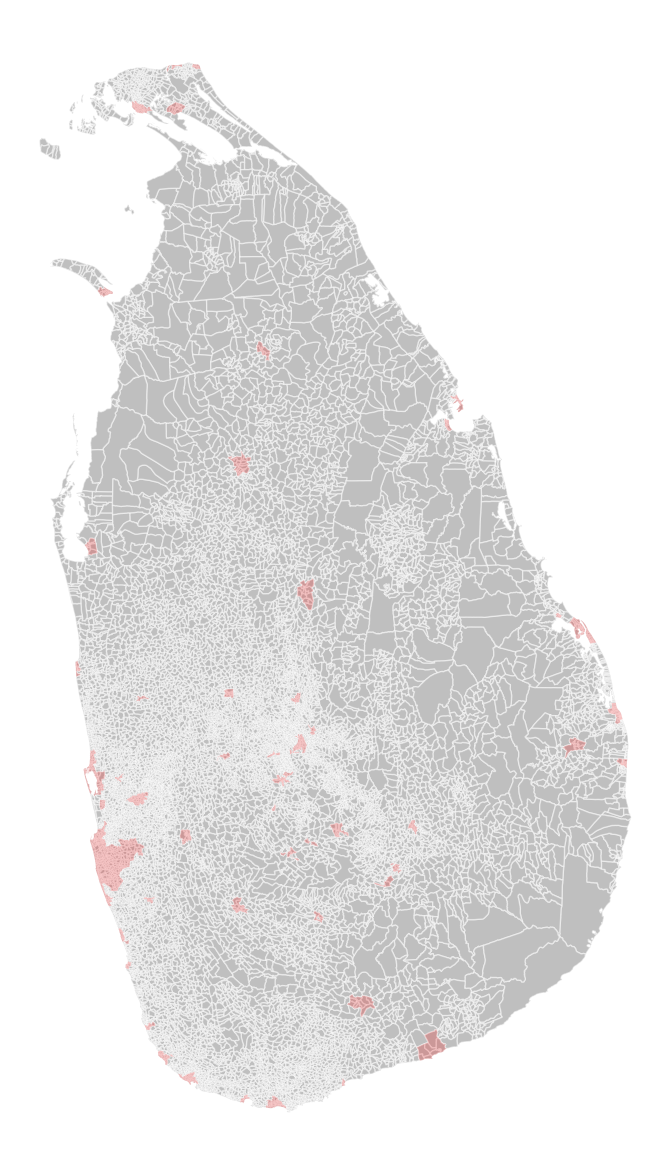

In [841]:
fig, ax = plt.subplots(1,1,figsize=(15, 15))

data_shapefile.plot(ax=ax,
        color='gray', 
        edgecolor='white',
        alpha=0.5)

gdf.plot(ax=ax, 
            color='red',
            markersize=1,
            alpha=0.2)

ax.axis('off')

# Ground Truth Map

Data obtained from principle component analysis

Text(0.5, 1.0, 'Ground truth map')

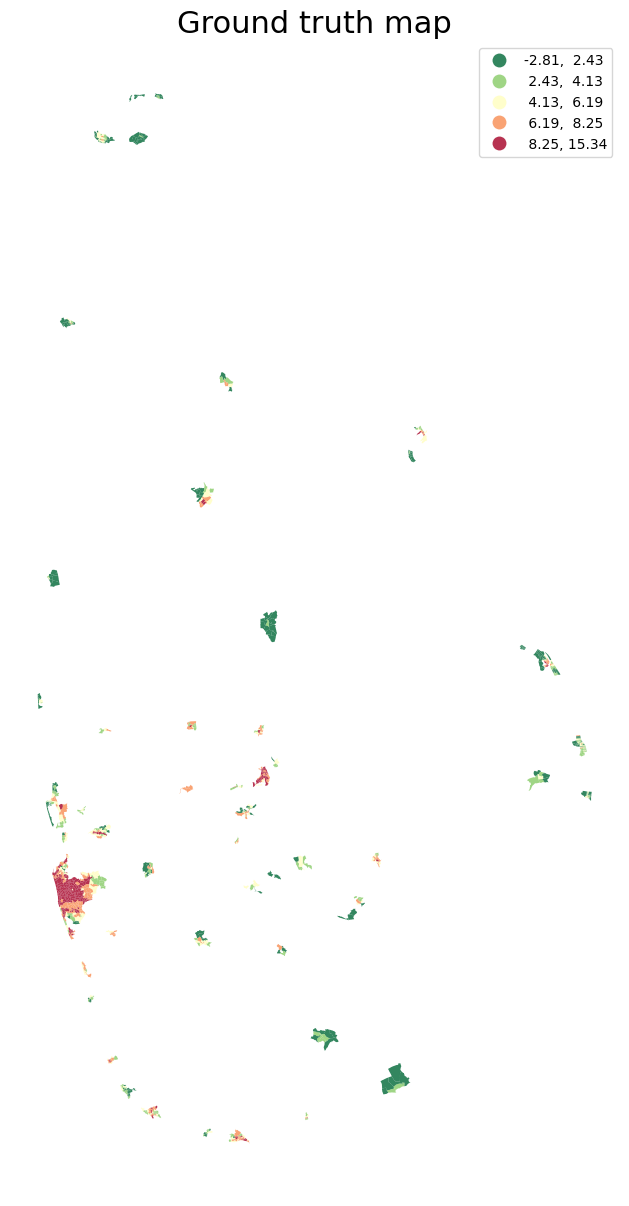

In [842]:
fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='pc1',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles') 

ax.axis('off')
ax.set_title('Ground truth map',fontsize=22)

## Modeling

We begin with a standard linear regression model, devoid of any geographical reference. From there, we formalize space and spatial relationships in three main ways: first, encoding it in exogenous variables; second, through spatial heterogeneity, or as systematic variation of outcomes across space; third, as dependence, or through the effect associated to the characteristics of spatial neighbors.

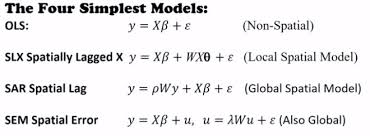


### 1. **Spatial Error Model (SEM)**

This model assumes that the error terms are spatially correlated, which means that the error at one location depends on the errors at nearby locations.

**Model Specification:**
\[ y = X\beta + u \]
\[ u = \lambda Wu + \epsilon \]


### 2. **Spatial Lag Model (SLM)**

The Spatial Lag Model (SLM) incorporates spatial dependence directly into the dependent variable. This model assumes that the value of the dependent variable at one location depends on the values of the dependent variable at neighboring locations.

**Model Specification:**
\[ y = \rho Wy + X\beta + \epsilon \]


### 3. **Spatial Durbin Error Model (SDEM)**

The Spatial Durbin Error Model (SDEM) extends the Spatial Error Model by including both spatial lags of the independent variables and spatially autocorrelated errors. This model captures both the direct and indirect effects of the independent variables, considering spatial spillovers.

**Model Specification:**
\[ y = X\beta + WX\theta + u \]
\[ u = \lambda Wu + \epsilon \]


## Ordinary Least Squares Model

In [843]:
'''
Adding a constant to allow the model to fit an intercept term.
'''
X_train_ols = sm.add_constant(data_train_scaled)

model = sm.OLS(y_train, X_train_ols)
model_OLS = model.fit()

print(model_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                    pc1   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     46.50
Date:                Sat, 03 Aug 2024   Prob (F-statistic):          4.59e-163
Time:                        14:28:48   Log-Likelihood:                -2079.6
No. Observations:                 972   AIC:                             4221.
Df Residuals:                     941   BIC:                             4372.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [844]:
X_test_ols = sm.add_constant(data_test_scaled)
y_pred = model_OLS.predict(X_test_ols)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 4.926887896601285
R-squared: 0.5805092475007285


In general, our model performs well, with a R squared value of 0.759. Since OLS models assumes independence of observations, which can lead to biased estimates and incorrect inferences in spatial data. Therefore Spatial models are preferred over OLS when studying spatial distribution because they account for spatial autocorrelation, where nearby locations tend to influence each other. Spatial models, like spatial lag or error models, and Spatial Durbin error models, consider this interdependence, enhancing our understanding of how spatial patterns influence the variable of interest and leading to more accurate and robust analyses, even if OLS provides a high R-squared value.
 

### Processing data for Spatial Models

In [845]:
'''
Step 01: Creating spatial weights matrix
Step 02: Convertiing the weights matrix to a sparse matrix for use in spreg
'''
w = weights.Queen.from_dataframe(merged_train)
w.transform = 'r'

('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 195, ' is an island (no neighbors)')
('WARNING: ', 231, ' is an island (no neighbors)')
('WARNING: ', 254, ' is an island (no neighbors)')
('WARNING: ', 356, ' is an island (no neighbors)')
('WARNING: ', 430, ' is an island (no neighbors)')
('WARNING: ', 622, ' is an island (no neighbors)')
('WARNING: ', 631, ' is an island (no neighbors)')
('WARNING: ', 658, ' is an island (no neighbors)')
('WARNING: ', 679, ' is an island (no neighbors)')
('WARNING: ', 715, ' is an island (no neighbors)')
('WARNING: ', 716, ' is an island (no neighbors)')
('WARNING: ', 892, ' is an island (no neighbors)')
('WARNING: ', 936, ' is an island (no neighbors)')
('WARNING: ', 937, ' is an island (no neighbors)')


/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_13699/2679821026.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(merged_train)
/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/.venv/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 75 disconnected components.
 There are 15 islands with ids: 154, 195, 231, 254, 356, 430, 622, 631, 658, 679, 715, 716, 892, 936, 937.
  W.__init__(self, neighbors, ids=ids, **kw)


#### There are 62 islands in Sri Lanka

Since these regions do not share boundaries with any other regions according to the spatial weights matrix. These islands can affect the spatial model's performance and interpretation.

**Approaches to Handle Islands**

1. Connect Islands to Nearest Neighbors

2. Remove Islands from the analysis

3. Use KNN instead of contiguity-based weights, so that for each observation we can have a fixed number of neighbors.


In [846]:
# Creating spatial weights matrix using KNN
#for train dataset
w = pysal.lib.weights.KNN.from_dataframe(merged_train)

#for full dataset
w_full = pysal.lib.weights.KNN.from_dataframe(merged)

/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/.venv/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 66 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/.venv/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 63 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


## Spatial Regression Model

In [847]:
if model_type == 1:
    model_SDEM = GM_Error_Het(data_unskewed['pc1'].values, data_unskewed.drop(columns=['pc1']).values, w=w_full, name_y='ground_truth', name_x=data_train_scaled.columns.tolist())
    print(model_SDEM.summary)

elif model_type== 2:
    '''
    model_SEM = spreg.ML_Error(y_train, X_train_scaled.values, w=w, name_x=['const'] + list(X_train_scaled.columns))
    print(model_SEM.summary)
    '''

    #SEM inferencing model

    #sem_model = pysal.model.spreg.GM_Error(y_train.values, data_train_scaled.values, w=w, name_y='ground_truth', name_x=data_train_scaled.columns.tolist())

    sem_model = pysal.model.spreg.GM_Error(data_unskewed['pc1'].values, data_unskewed.drop(columns=['pc1']).values, w=w_full, name_y='ground_truth', name_x=data_train_scaled.columns.tolist())
    print(sem_model.summary)

elif model_type== 3:
    
    slx_model = pysal.model.spreg.ML_Lag(data_unskewed['pc1'].values, data_unskewed.drop(columns=['pc1']).values, w=w_full, name_y='ground_truth', name_x=data_train_scaled.columns.tolist())
    print(slx_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :ground_truth                Number of Observations:        1216
Mean dependent var  :      5.2681                Number of Variables   :          32
S.D. dependent var  :      3.2795                Degrees of Freedom    :        1184
Pseudo R-squared    :      0.5568
Spatial Pseudo R-squared:  0.0340
Log likelihood      :  -3188.2317
Sigma-square ML     :      7.9896                Akaike info criterion :    6440.463
S.E of regression   :      2.8266                Schwarz criterion     :    6603.770

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/.venv/lib/python3.11/site-packages/spreg/diagnostics.py:354: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/.venv/lib/python3.11/site-packages/spreg/diagnostics.py:170: RuntimeWarning: invalid value encountered in sqrt
  ) / np.sqrt(variance)


**The most common statistical methods to compare spatial models**

1. **Akaike Information Criterion (AIC)** : A lower AIC value generally indicates a better model.
2.  **Bayesian Information Criterion (BIC)**: A lower BIC value generally indicates a better model.
3. **Log-Likelihood** : This is a measure of how well the model explains the data. Higher log-likelihood values indicate a better fit.


**Computation**

AIC (Akaike Information Criterion) = 2k - 2ln(L)

BIC (Bayesian Information Criterion) = kln(n) - 2ln(L)

where,

k is the number of parameters
L is the maximized value of the likelihood function of the model
n is the number of observations

In [848]:
'''
# residuals for SEM model
residuals_sem = sem_model.y - sem_model.predy
# residuals for SLX model
residuals_slx = slx_model.y - slx_model.predy

# Log-Likelihood for SEM
mse_sem = mean_squared_error(sem_model.y.flatten(), sem_model.predy.flatten())
llf_sem = -0.5 * len(sem_model.y) * np.log(2 * np.pi * mse_sem) - 0.5 * np.sum(np.array(residuals_sem)**2) / mse_sem

# Log-Likelihood for SLX
mse_slx = mean_squared_error(slx_model.y.flatten(), slx_model.predy.flatten())
llf_slx = -0.5 * len(slx_model.y) * np.log(2 * np.pi * mse_slx) - 0.5 * np.sum(np.array(residuals_slx)**2) / mse_slx

k_sem = len(sem_model.betas)
k_slx = len(slx_model.betas)

aic_sem = 2.0*k_sem - 2*llf_sem

bic_sem = np.log(len(sem_model.y))*k_sem - 2*llf_sem

aic_slx = 2.0*k_slx - 2*llf_slx

bic_slx = np.log(len(slx_model.y))*k_slx - 2*llf_slx

# residuals for SDEM model
residuals_sdem = model_SDEM.y - model_SDEM.predy

mse_sdem = mean_squared_error(model_SDEM.y.flatten(), model_SDEM.predy.flatten())

llf_sdem = -0.5 * len(model_SDEM.y) * np.log(2 * np.pi * mse_sdem) - 0.5 * np.sum(np.array(residuals_sdem)**2) / mse_sdem

k_sdem = len(model_SDEM.betas)

aic_sdem = 2.0*k_sdem - 2*llf_sdem


bic_sdem = np.log(len(model_SDEM.y))*k_sdem - 2*llf_sdem

print('AIC')
print('SEM AIC: ', aic_sem)
print('SLX AIC: ', aic_slx)
#print('SDEM AIC: ', aic_sdem)


print('BIC')
print('SEM BIC: ', bic_sem)
print('SLX BIC: ', bic_slx)
#print('SDEM BIC: ', bic_sdem)

'''

"\n# residuals for SEM model\nresiduals_sem = sem_model.y - sem_model.predy\n# residuals for SLX model\nresiduals_slx = slx_model.y - slx_model.predy\n\n# Log-Likelihood for SEM\nmse_sem = mean_squared_error(sem_model.y.flatten(), sem_model.predy.flatten())\nllf_sem = -0.5 * len(sem_model.y) * np.log(2 * np.pi * mse_sem) - 0.5 * np.sum(np.array(residuals_sem)**2) / mse_sem\n\n# Log-Likelihood for SLX\nmse_slx = mean_squared_error(slx_model.y.flatten(), slx_model.predy.flatten())\nllf_slx = -0.5 * len(slx_model.y) * np.log(2 * np.pi * mse_slx) - 0.5 * np.sum(np.array(residuals_slx)**2) / mse_slx\n\nk_sem = len(sem_model.betas)\nk_slx = len(slx_model.betas)\n\naic_sem = 2.0*k_sem - 2*llf_sem\n\nbic_sem = np.log(len(sem_model.y))*k_sem - 2*llf_sem\n\naic_slx = 2.0*k_slx - 2*llf_slx\n\nbic_slx = np.log(len(slx_model.y))*k_slx - 2*llf_slx\n\n# residuals for SDEM model\nresiduals_sdem = model_SDEM.y - model_SDEM.predy\n\nmse_sdem = mean_squared_error(model_SDEM.y.flatten(), model_SDEM.predy.

**Selection**

According to these criteria, SLX model appears to be the best performing model. However, since we are more interested in **Spatial error effect** rather than **Spatial lag effect** the selection among SEM or SDEM model is more appropriate. So considering the above AIC/ BIC criteria, SDEM model is selected as the best performing model.



## Results visualization 

In [849]:
if model_type == 1:
    merged['pred_ground_truth'] = model_SDEM.predy.flatten()

elif model_type== 2:
    merged['pred_ground_truth'] = sem_model.predy.flatten()

elif model_type== 3:
    merged['pred_ground_truth'] = slx_model.predy.flatten()    

Text(0.5, 1.0, '')

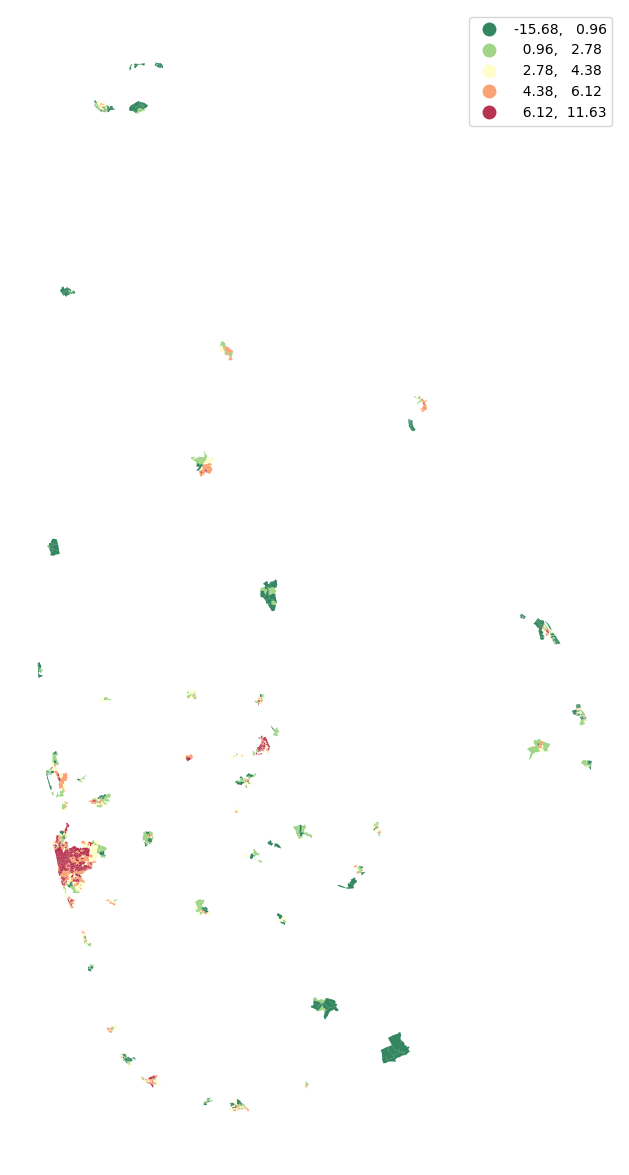

In [850]:
#merged = data_unskewed.merge(data_shapefile, left_on=data_unskewed.code_7, right_on='code_7', how='inner')
gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)

fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='pred_ground_truth',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles') 

ax.axis('off')
ax.set_title('',fontsize=22)

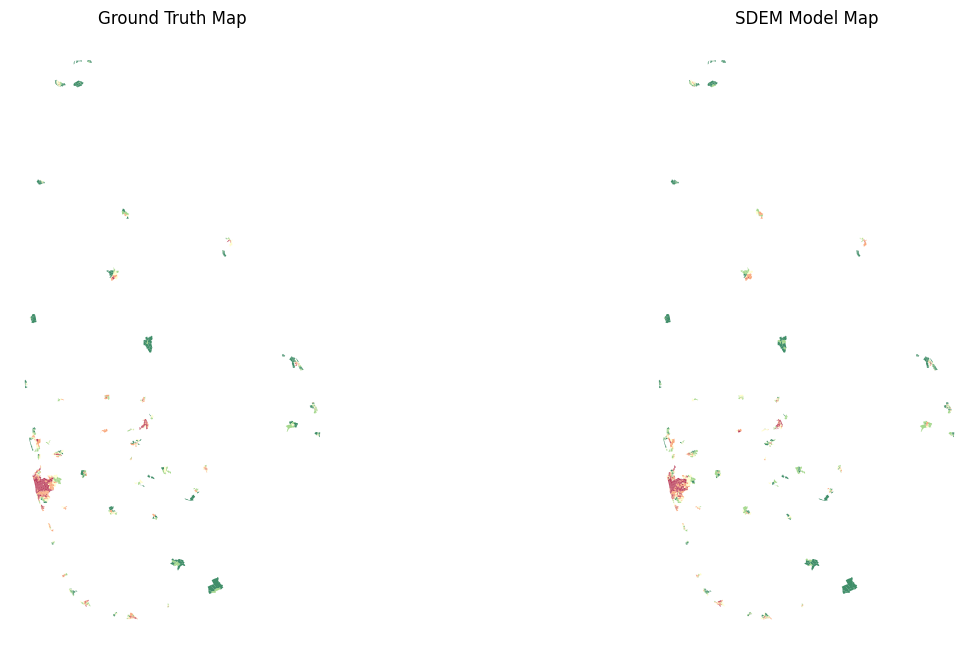

In [851]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

gdf.plot(ax=ax[0],
         column='pc1', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Ground Truth Map")


gdf.plot(ax=ax[1],
         column='pred_ground_truth', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("SDEM Model Map")

plt.show()

## Evaluating model performance 

### 1. Predicting poorest 100, 500, 1000, 3000 GNDS

In [852]:
def prediction_performance(A, B):
    
    B_set = set(B)
    count = 0
    
    for element in A:
        if element in B_set:
            count += 1
            
    return count

In [853]:
for i in (100, 500, 1000, 3000):
    merged = merged.sort_values('pc1')
    pc_top = merged.iloc[:i]
    index_values_pc = pc_top.index.values

    merged = merged.sort_values('pred_ground_truth')

    df_top = merged.iloc[:i]   
    index_values_top = df_top.index.values

    print(f'Predicting poorest {i} Gnds: ',(prediction_performance(index_values_pc, index_values_top) / i )*100)


Predicting poorest 100 Gnds:  41.0
Predicting poorest 500 Gnds:  74.4
Predicting poorest 1000 Gnds:  91.3
Predicting poorest 3000 Gnds:  40.53333333333333


### 2. Predicting poorest 25, 50, 100 DSDs

In [854]:
# Read DSD-level poverty data
dsd_poverty = pd.read_csv("/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/dsd-poverty.csv")
#Read census features 
census = pd.read_csv("/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/census_features.csv", usecols=["gnd_id", "age_total"])
census = census.rename(columns={"age_total": "pop"})

data_b2 = merged[['code_7', 'pc1', 'pred_ground_truth']].copy()

# Merge predicted values with the census data

merged2 = data_b2.merge(census, left_on=data_b2.code_7, right_on='gnd_id', how='inner')

# Merge with data_shapefile

gnd2dsd_df = data_shapefile.drop(columns="geometry")
merged2 = merged2.merge(gnd2dsd_df, left_on=merged.code_7, right_on=gnd2dsd_df.index, how='inner')

#Taking the Gnd level predicted data to the DSD level

dsd_grouped = merged2.groupby("dsd_name").apply(lambda x: (x["pred_ground_truth"] * x["pop"]).sum() / x["pop"].sum()).reset_index(name="fit_wted")

# Rename the misspelled columns using FizzBuzz

dsd_grouped["dsd_name"] = dsd_grouped["dsd_name"].apply(
  lambda x: process.extractOne(x, dsd_poverty["dsd_name"], scorer=fuzz.partial_ratio)[0]
)

dsd_final = dsd_grouped.merge(dsd_poverty, on='dsd_name', how='inner')

/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_13699/2107854258.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dsd_grouped = merged2.groupby("dsd_name").apply(lambda x: (x["pred_ground_truth"] * x["pop"]).sum() / x["pop"].sum()).reset_index(name="fit_wted")


In [855]:
for x in (25, 50, 100):

    predicted_list = dsd_grouped.sort_values(by="fit_wted", ascending=False)
    predicted_list = predicted_list.head(x).copy()
    predicted_list = predicted_list.dsd_name.to_list()


    hc_list = dsd_poverty.sort_values(by="headcount_index", ascending=True)
    hc_list = hc_list.head(x).copy()
    hc_list = hc_list.dsd_name.to_list()

    series_a = pd.Series(predicted_list)
    series_b = pd.Series(hc_list)


    percentage = (series_b.isin(predicted_list).sum() / len(series_b)) * 100

    print(f"The percentage of predicting poorest {x} DSDs: {percentage}%")

The percentage of predicting poorest 25 DSDs: 60.0%
The percentage of predicting poorest 50 DSDs: 64.0%
The percentage of predicting poorest 100 DSDs: 47.0%
